In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

%matplotlib inline


I. Get the time series for the following cryptocurrencies from cryptowat.ch starting from 2021-11-22, hourly data: 
- ETH
- SOL
- AVAX
- USDT
- FLOW

In [2]:
def get_data(token):
    # All coins except FLOW are in coinbase-pro, kraken used for FLOW
    if token != 'FLOW':
        exchange = f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc'
    else: 
        exchange = f'https://api.cryptowat.ch/markets/kraken/{token}usd/ohlc'
    
    res = requests.get(
        exchange,
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [3]:
tokens = ['ETH', 'SOL', 'AVAX', 'USDT', 'FLOW']

In [4]:
df_base = pd.concat(get_data(token) for token in tokens)


In [5]:
df_base

,ts,open,high,low,close,volume,volumeUSD,token
0,2021-11-22 00:00:00,4317.980,4342.240,4246.070,4262.990,7262.562789,3.123077e+07,ETH
1,2021-11-22 01:00:00,4263.040,4270.340,4212.450,4234.370,8437.946084,3.574586e+07,ETH
2,2021-11-22 02:00:00,4234.870,4246.720,4171.170,4217.890,9259.725370,3.895639e+07,ETH
3,2021-11-22 03:00:00,4217.880,4223.480,4163.580,4193.470,9259.899519,3.882032e+07,ETH
4,2021-11-22 04:00:00,4192.950,4213.590,4147.000,4168.350,7934.546906,3.315476e+07,ETH
...,...,...,...,...,...,...,...,...
643,2021-12-18 19:00:00,8.500,8.534,8.500,8.524,2851.583332,2.431116e+04,FLOW
644,2021-12-18 20:00:00,8.524,8.524,8.460,8.499,8219.960211,6.977798e+04,FLOW
645,2021-12-18 21:00:00,8.498,8.498,8.473,8.482,3100.106110,2.630808e+04,FLOW
646,2021-12-18 22:00:00,8.486,8.504,8.482,8.503,1282.237200,1.089121e+04,FLOW


II. Get the total USD volume traded for each token in a dataframe, sorted from highest volume to lowest volume

In [6]:
df_base[['token','volumeUSD']].groupby(['token']).sum().sort_values('volumeUSD')

,volumeUSD
token,
FLOW,9.641772e+07
USDT,2.232682e+09
AVAX,4.356431e+09
SOL,8.082956e+09
ETH,2.469536e+10


III. Add a column that calculates the close price ratio between ETH and SOL for each hour (i.e. close price of ETH / close price of SOL for each period)

In [7]:
# get ETH closings
close_ETH = df_base.loc[df_base.token == 'ETH', ['ts','close']]
close_ETH.rename(columns = {'close':'ETH_close'}, inplace=True)
# get SOL closings
close_SOL = df_base.loc[df_base.token == 'SOL', ['ts','close']]
close_SOL.rename(columns = {'close':'SOL_close'}, inplace=True)
# merge both dataframes by ts
closings = pd.merge(close_ETH, close_SOL, how='left', on='ts')
# calculate ratio
closings['close_price_ratio'] = closings['ETH_close']/closings['SOL_close']
# add the column to the original dataframe
df_base = pd.merge(df_base, closings[['ts','close_price_ratio']], how='left', on='ts')

In [8]:
df_base

,ts,open,high,low,close,volume,volumeUSD,token,close_price_ratio
0,2021-11-22 00:00:00,4317.980,4342.240,4246.070,4262.990,7262.562789,3.123077e+07,ETH,18.471694
1,2021-11-22 01:00:00,4263.040,4270.340,4212.450,4234.370,8437.946084,3.574586e+07,ETH,18.736150
2,2021-11-22 02:00:00,4234.870,4246.720,4171.170,4217.890,9259.725370,3.895639e+07,ETH,18.577985
3,2021-11-22 03:00:00,4217.880,4223.480,4163.580,4193.470,9259.899519,3.882032e+07,ETH,18.794937
4,2021-11-22 04:00:00,4192.950,4213.590,4147.000,4168.350,7934.546906,3.315476e+07,ETH,18.891059
...,...,...,...,...,...,...,...,...,...
3235,2021-12-18 19:00:00,8.500,8.534,8.500,8.524,2851.583332,2.431116e+04,FLOW,21.706281
3236,2021-12-18 20:00:00,8.524,8.524,8.460,8.499,8219.960211,6.977798e+04,FLOW,21.701133
3237,2021-12-18 21:00:00,8.498,8.498,8.473,8.482,3100.106110,2.630808e+04,FLOW,21.712132
3238,2021-12-18 22:00:00,8.486,8.504,8.482,8.503,1282.237200,1.089121e+04,FLOW,21.619845


IV. Change the name of the volume and volumeUSD columns to volumeBase and volumeTerm

In [9]:
df_base.rename(columns={'volume':'volumeBase','volumeUSD':'volumeTerm'}, inplace=True)
df_base

,ts,open,high,low,close,volumeBase,volumeTerm,token,close_price_ratio
0,2021-11-22 00:00:00,4317.980,4342.240,4246.070,4262.990,7262.562789,3.123077e+07,ETH,18.471694
1,2021-11-22 01:00:00,4263.040,4270.340,4212.450,4234.370,8437.946084,3.574586e+07,ETH,18.736150
2,2021-11-22 02:00:00,4234.870,4246.720,4171.170,4217.890,9259.725370,3.895639e+07,ETH,18.577985
3,2021-11-22 03:00:00,4217.880,4223.480,4163.580,4193.470,9259.899519,3.882032e+07,ETH,18.794937
4,2021-11-22 04:00:00,4192.950,4213.590,4147.000,4168.350,7934.546906,3.315476e+07,ETH,18.891059
...,...,...,...,...,...,...,...,...,...
3235,2021-12-18 19:00:00,8.500,8.534,8.500,8.524,2851.583332,2.431116e+04,FLOW,21.706281
3236,2021-12-18 20:00:00,8.524,8.524,8.460,8.499,8219.960211,6.977798e+04,FLOW,21.701133
3237,2021-12-18 21:00:00,8.498,8.498,8.473,8.482,3100.106110,2.630808e+04,FLOW,21.712132
3238,2021-12-18 22:00:00,8.486,8.504,8.482,8.503,1282.237200,1.089121e+04,FLOW,21.619845


V. create a fat table indexed by the timestamp, and each column is the close price of each token (i.e. this should be a table of 200 rows and 5 columns)

In [10]:
fat_table = pd.pivot_table(df_base[['ts', 'close', 'token']], values='close', index='ts', columns='token')
fat_table

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 00:00:00,128.67,4262.99,14.150,230.785,1.0012
2021-11-22 01:00:00,134.85,4234.37,13.621,226.000,1.0013
2021-11-22 02:00:00,132.54,4217.89,13.753,227.037,1.0012
2021-11-22 03:00:00,133.38,4193.47,13.652,223.117,1.0011
2021-11-22 04:00:00,136.29,4168.35,13.581,220.652,1.0009
...,...,...,...,...,...
2021-12-18 19:00:00,115.10,3943.38,8.524,181.670,1.0003
2021-12-18 20:00:00,113.89,3945.70,8.499,181.820,1.0005
2021-12-18 21:00:00,114.31,3960.51,8.482,182.410,1.0004


VI. calculate the hour by hour log return of the close price of each token (return is calculated by np.log(price_t / price_{t-1}))

In [11]:
returns = np.log(fat_table/fat_table.shift(1))
returns.dropna(axis=0, inplace=True)
returns

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 01:00:00,0.046912,-0.006736,-0.038102,-0.020952,0.0001
2021-11-22 02:00:00,-0.017279,-0.003900,0.009644,0.004578,-0.0001
2021-11-22 03:00:00,0.006318,-0.005806,-0.007371,-0.017417,-0.0001
2021-11-22 04:00:00,0.021583,-0.006008,-0.005214,-0.011109,-0.0002
2021-11-22 05:00:00,-0.031832,-0.002472,-0.014014,-0.015161,-0.0001
...,...,...,...,...,...
2021-12-18 19:00:00,0.004005,0.001553,0.002820,-0.000275,-0.0001
2021-12-18 20:00:00,-0.010568,0.000588,-0.002937,0.000825,0.0002
2021-12-18 21:00:00,0.003681,0.003746,-0.002002,0.003240,-0.0001


VII. [Stretch] calculate the correlation of the tokens using the table above

In [12]:
returns.corr()

token,AVAX,ETH,FLOW,SOL,USDT
token,,,,,
AVAX,1.000000,0.656539,0.404425,0.648571,0.010301
ETH,0.656539,1.000000,0.582176,0.757277,-0.090674
FLOW,0.404425,0.582176,1.000000,0.476138,-0.176508
SOL,0.648571,0.757277,0.476138,1.000000,0.108753
USDT,0.010301,-0.090674,-0.176508,0.108753,1.000000


VII. [Stretch] visualize the correlation in a matplpotlib plot

C:\Users\Tonijua\AppData\Local\Temp/ipykernel_17680/186299479.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+tokens)
C:\Users\Tonijua\AppData\Local\Temp/ipykernel_17680/186299479.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+tokens)


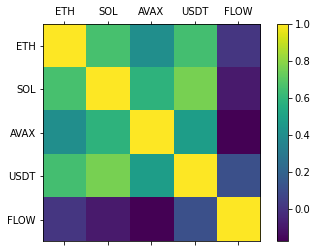

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(returns.corr())
fig.colorbar(cax)

ax.set_xticklabels(['']+tokens)
ax.set_yticklabels(['']+tokens)

plt.show()